<a href="https://colab.research.google.com/github/lkaplan25/AV_conjoint_survey_2022/blob/main/Final_Regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive

df = pd.read_csv('player_stats_position_salary.csv')

In [ ]:
df.head()

,Unnamed: 0,PLAYER_NAME,REAL_GAME_YEAR,GAME_ID,TEAM_ID,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,...,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,Primary Position,Secondary Postion,SEASON_USED_FOR_SALARY_CALC,RESULTING_SALARY_NEXT_SEASON
0,4,Aaron Brooks,2007.0,1299937515,91804926465,11466462,101.0,250.0,21.581,36.0,...,24.813,41.468,20.118,1125.0,2419.0,30,G,NaN,2007,1045560.0
1,15,Aaron Brooks,2008.0,2194451304,149786985285,18708438,393.0,953.0,36.071,140.0,...,41.097,72.011,33.650,1735.0,3708.0,62,G,NaN,2008,1118520.0
2,26,Aaron Brooks,2009.0,1713850693,132070245090,16495612,575.0,1331.0,35.556,209.0,...,37.455,63.174,28.749,1704.0,3509.0,45,G,NaN,2009,2016692.0
3,48,Aaron Brooks,2012.0,1370825166,95026152553,11868794,156.0,350.0,23.274,51.0,...,25.844,45.953,20.458,1254.0,2413.0,40,G,NaN,2012,2211837.0
4,59,Aaron Brooks,2013.0,1533645391,115964117582,14483952,233.0,581.0,23.913,96.0,...,32.081,51.504,25.293,1510.0,3132.0,47,G,NaN,2013,1145685.0


# Data Cleaning

One final data cleaning step that is required is to adjust the field goal percentage data `FG_PCT` to provide the correct aggregate percentage for the season. We calculate the correct percentages by deleting the column with the incorrect values and recalculating the percentages. For example, `FG_PCT` in the original dataframe included data on each player's field goal percentage. We recalculated this column by saying if `FGA` is greater than 0, then it is equal to `FGM` divided by `FGA`.

We also added additional data to complete the aggregation for the player data. This includes `FT_RATE` and `EFF_FG%` which are known as free throw rate and effective field goal percentage. These two stats are well-known as two of the “Four Factors” which are commonly used as part of the statistical evaluation of player performance and can be easily calculated with box score data. 

Finally, we convert all the salary data into 2022 dollar equivalents using annual Consumer Price Index (CPI) information. 


In [ ]:
#df.head()
#df.drop('Unnamed: 0')
#df = df.drop(columns=['FG_PCT', 'FG3_PCT', 'FT_PCT'])

# Calculating field goal percentage, free throw rate, and effective field goal percentage
df['FG_PCT']=np.where(df['FGA']<=0, 0, df['FGM']/df['FGA'])
df['3FG_PCT']=np.where(df['FG3A']<=0, 0, df['FG3M']/df['FG3A'])
df['FT_PCT']=np.where(df['FTA']<=0, 0, df['FTM']/df['FTA'])
df['FT_RATE']=np.where(df['FGA']<=0, 0, df['FTA']/df['FGA'])
df['EFF_FG%']=np.where(df['FGA']<=0, 0, (df['FGM']+0.5*df['FG3M'])/df['FGA'])
df = df[df['FGA']!=0]
print(len(df))
#min(list(df['RESULTING_SALARY_NEXT_SEASON']))

# Adjusting for inflation
CPI_list = {1985: 107.6, 1986: 109.6, 1987: 113.6, 1988: 118.3, 1989: 124.0, 1990: 130.7, 1991: 136.2, 1992: 140.3, 1993: 144.5, 1994: 148.2, 1995: 152.4, 1996: 156.9, 1997: 160.5, 1998: 163.0, 1999: 166.6, 2000: [172.2], 2001: [177.1], 2002: [179.9], 2003: [184.0], 2004: [188.9], 2005: [195.3], 2006: [201.6], 2007: [207.3], 2008: [215.3], 2009: [214.5], 2010: [218.1], 2011: [224.9], 2012: [229.6], 2013: [233.0], 2014: [234.8], 2015: [236.5], 2016: [241.4], 2017: [246.5], 2018: [251.2], 2019: [257.0], 2020: [260.5], 2021: [278.8], 2022: [298.0]}
cpDF = pd.DataFrame.from_dict(CPI_list)
cpDF = cpDF.transpose()
cpDF = cpDF.reset_index()
cpDF.columns = ["Year", "CPI"]
#cpDF.head(10)
list(df.columns)
df['SEASON_USED_FOR_SALARY_CALC'].dtype
df = df.merge(cpDF, how='inner', left_on='SEASON_USED_FOR_SALARY_CALC', right_on='Year')
df["Adjusted Salary"] = ((298.001-df['CPI'])/df['CPI'])*df['RESULTING_SALARY_NEXT_SEASON']
df = df.rename(columns = {'Primary Position': 'Temp_Position'})
conditions = [(df['Temp_Position']=='C'), (df['Temp_Position']=='F'), (df['Temp_Position']=='G')]
values = [3, 2, 1]
df['Primary Position'] = np.select(conditions, values)
df = df.loc[~(((df['FG_PCT']>0.8) | (df['FGA']<80)) | ((df['FT_PCT']>0.9) & (df['FTA']<40))), :]
df.head()
print(len(df))

4900
4267


In [ ]:
df.columns

Index(['Unnamed: 0', 'PLAYER_NAME', 'REAL_GAME_YEAR', 'GAME_ID', 'TEAM_ID',
       'PLAYER_ID', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',
       'PTS', 'PLUS_MINUS', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON',
       'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'PTS_away',
       'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS', 'Temp_Position', 'Secondary Postion',
       'SEASON_USED_FOR_SALARY_CALC', 'RESULTING_SALARY_NEXT_SEASON',
       '3FG_PCT', 'FT_RATE', 'EFF_FG%', 'Year', 'CPI', 'Adjusted Salary',
       'Primary Position'],
      dtype='object')

# Exploratory Analysis

## Transformation of the Dependent Variable

Regression analysis aims to assess the extent of linear dependence between explanatory variables and a dependent variable. A lack of normality in the data can cause problems with assumptions underlying our regression analysis. At the start of our analysis, we therefore want to check if the dependent variable (player salary) is normally distributed.

(array([ 77.,  69., 382., 323., 278., 181., 178., 188., 179., 162., 149.,
        152., 125.,  78., 125., 111.,  95.,  81.,  91.,  59.,  56.,  66.,
         40.,  78.,  69.,  46.,  35.,  37.,  40.,  27.,  31.,  43.,  29.,
         28.,  49.,  34.,  30.,  24.,  32.,  30.,  24.,  21.,  32.,  29.,
         14.,  17.,  12.,  28.,   9.,  18.,   7.,  14.,   8.,   6.,  12.,
          7.,  12.,   9.,   2.,   4.,   5.,  10.,   1.,   7.,   6.,   7.,
          7.,   1.,   4.,   1.,   3.,   0.,   2.,   0.,   1.,   2.,   6.,
          0.,   0.,   2.,   0.,   1.,   3.,   0.,   0.,   2.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([8.31300000e+03, 3.55055370e+05, 7.01797740e+05, 1.04854011e+06,
        1.39528248e+06, 1.74202485e+06, 2.08876722e+06, 2.43550959e+06,
        2.78225196e+06, 3.12899433e+06, 3.47573670e+06, 3.82247907e+06,
        4.16922144e+06, 4.51596381e+06, 4.86270618e+06, 5.20944855e+06,
        5.55619092e+06, 5.9029

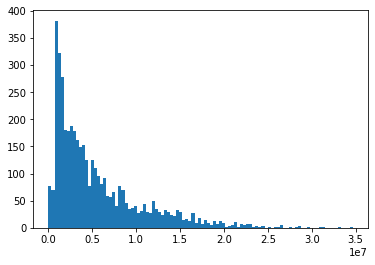

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['RESULTING_SALARY_NEXT_SEASON'], bins = 100)

The distribution of the dependent variable is right-skewed. There are a few players with very high salaries, but the majority of the salaries fall within a lower range. To improve the performance of our regression model, we choose to transform the dependent variable. 

(array([ 75.,  33., 279., 331., 235., 195., 167., 184., 188., 142., 124.,
        109., 129., 108., 119.,  97.,  64.,  93.,  71.,  53.,  68.,  63.,
         61.,  64.,  70.,  65.,  54.,  48.,  40.,  53.,  46.,  29.,  36.,
         32.,  37.,  39.,  42.,  48.,  44.,  39.,  34.,  29.,  17.,  23.,
         27.,  19.,  12.,  28.,  21.,  17.,  17.,   7.,  22.,  12.,  18.,
         14.,  13.,  19.,  19.,  13.,  13.,   5.,  15.,   6.,   2.,   2.,
          3.,   3.,   3.,   3.,   9.,  12.,   7.,   2.,   1.,   1.,   1.,
          0.,   0.,   0.,   1.,   4.,  12.,   0.,   1.,   2.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([1.94914711e+03, 1.12387921e+05, 2.22826694e+05, 3.33265468e+05,
        4.43704241e+05, 5.54143015e+05, 6.64581788e+05, 7.75020561e+05,
        8.85459335e+05, 9.95898108e+05, 1.10633688e+06, 1.21677566e+06,
        1.32721443e+06, 1.43765320e+06, 1.54809198e+06, 1.65853075e+06,
        1.76896952e+06, 1.8794

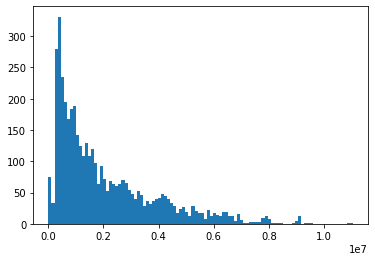

In [ ]:
plt.hist(df['Adjusted Salary'], bins = 100)

(array([ 3.,  2., 23., 17.,  6., 31., 28., 33., 30., 23., 46., 22., 36.,
        61., 42., 27., 51., 70., 50., 30., 37., 44., 43., 42., 39., 48.,
        56., 43., 36., 40., 39., 42., 37., 60., 55., 62., 45., 63., 65.,
        63., 57., 52., 50., 64., 49., 37., 61., 60., 69., 68., 54., 71.,
        57., 63., 38., 56., 68., 51., 42., 44., 61., 56., 56., 56., 57.,
        77., 62., 54., 45., 57., 52., 42., 42., 54., 63., 65., 64., 55.,
        35., 45., 33., 43., 36., 31., 32., 31., 38., 28., 21.,  7.,  9.,
        26.,  6.,  1.,  4., 14.,  4.,  0.,  0.,  2.]),
 array([5.30603868, 5.32341028, 5.34078187, 5.35815347, 5.37552506,
        5.39289666, 5.41026825, 5.42763985, 5.44501144, 5.46238304,
        5.47975463, 5.49712623, 5.51449782, 5.53186942, 5.54924102,
        5.56661261, 5.58398421, 5.6013558 , 5.6187274 , 5.63609899,
        5.65347059, 5.67084218, 5.68821378, 5.70558537, 5.72295697,
        5.74032856, 5.75770016, 5.77507176, 5.79244335, 5.80981495,
        5.82718654, 5.8445

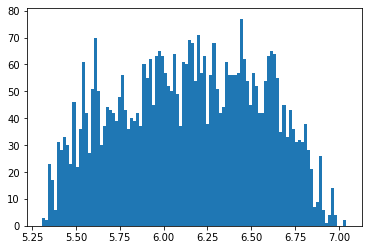

In [ ]:
#df['log_salary'] = np.log10(df['RESULTING_SALARY_NEXT_SEASON'])
df['log_salary'] = np.log10(df['Adjusted Salary'])
df = df[df['log_salary']>5.3]
plt.hist(df['log_salary'], bins = 100)

The transformed distribution is now somewhat left-skewed but overall appears more normally distributed so we will move forward with using the transformed dependent variable, `log_salary`.

## Correlation Analysis

Our dataset includes many different variables related to the players and the games in which they played. Not all of these variables will necessarily help with the accuracy of our predictive salary model. We perform a correlation analysis to look at the relationships between our dependent variable and all of the potential explanatory variables that we could use in our model.

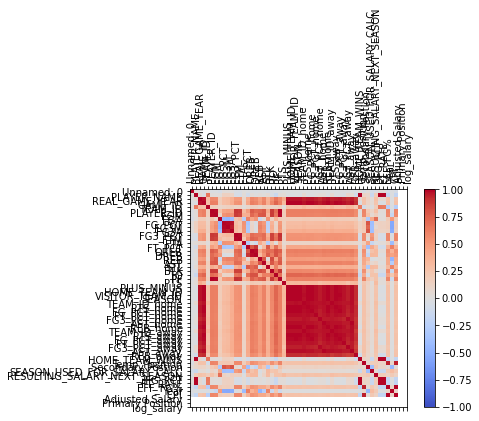

In [ ]:
corr = df.corr(method = 'spearman')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
#plt.savefig('images/heatMap1.png', dpi=200, transparent = True)  
plt.show()

The correlation matrix is rather large and unwieldy, making it difficult to identify which independent variables are most highly correlated with player salary. An alternative approach to narrow down variables is to perform stepwise linear regression.

In [ ]:
correlations = df.corr()
correlations.sort_values(by = ['RESULTING_SALARY_NEXT_SEASON'], ascending=False)

,Unnamed: 0,REAL_GAME_YEAR,GAME_ID,TEAM_ID,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,FG3A,...,SEASON_USED_FOR_SALARY_CALC,RESULTING_SALARY_NEXT_SEASON,3FG_PCT,FT_RATE,EFF_FG%,Year,CPI,Adjusted Salary,Primary Position,log_salary
RESULTING_SALARY_NEXT_SEASON,-0.051483,0.180145,0.216067,0.191781,-0.081382,0.602595,0.578622,0.191992,0.275502,0.285198,...,0.180145,1.000000,0.068478,0.158610,0.187943,0.180145,0.166681,0.891486,0.096860,0.834014
Adjusted Salary,-0.047739,-0.170542,0.191968,0.196904,-0.204610,0.594897,0.576734,0.168549,0.221138,0.230344,...,-0.170542,0.891486,0.036910,0.190351,0.120283,-0.170542,-0.182885,1.000000,0.098629,0.906687
log_salary,-0.055231,-0.188967,0.240241,0.254948,-0.238422,0.586935,0.573187,0.170551,0.236277,0.242878,...,-0.188967,0.834014,0.028047,0.173251,0.128396,-0.188967,-0.198169,0.906687,0.104062,1.000000
PTS,-0.035083,0.018793,0.539855,0.565942,-0.013602,0.989139,0.985286,0.161828,0.552119,0.569179,...,0.018793,0.603978,0.224433,0.132823,0.221427,0.018793,0.018711,0.595217,-0.098438,0.584159
FGM,-0.032866,0.019283,0.549124,0.577153,-0.012635,1.000000,0.984670,0.214360,0.486701,0.503352,...,0.019283,0.602595,0.184949,0.091516,0.234693,0.019283,0.019867,0.594897,-0.057388,0.586935
FGA,-0.021889,0.013176,0.540468,0.572603,-0.009611,0.984670,1.000000,0.074196,0.571860,0.596419,...,0.013176,0.578622,0.252102,0.030441,0.137634,0.013176,0.012354,0.576734,-0.143682,0.573187
FTA,-0.064539,-0.046106,0.427490,0.453810,-0.037670,0.855979,0.831812,0.236573,0.285815,0.312002,...,-0.046106,0.565306,0.048058,0.473654,0.148979,-0.046106,-0.045296,0.579321,0.028488,0.550085
FTM,-0.057244,-0.040458,0.415137,0.440400,-0.034975,0.861306,0.851368,0.166420,0.353991,0.378946,...,-0.040458,0.559761,0.109430,0.407896,0.115914,-0.040458,-0.039477,0.571971,-0.039367,0.543235
DREB,-0.034710,0.031246,0.529854,0.552753,-0.010229,0.705746,0.640420,0.424925,0.121257,0.127639,...,0.031246,0.531580,-0.119236,0.266811,0.316536,0.031246,0.028595,0.519754,0.378710,0.520217
TO,-0.027539,-0.031830,0.498037,0.532608,-0.019325,0.859719,0.865887,0.111474,0.407255,0.438525,...,-0.031830,0.516401,0.145080,0.200518,0.086746,-0.031830,-0.032593,0.523986,-0.128657,0.528794


# Regression Analysis

## Splitting Data into Train (70%) and Test (30%) sets

In [ ]:
from sklearn.model_selection import train_test_split

X_set = df.drop(['Unnamed: 0', 'PLAYER_NAME', 'GAME_ID', 'TEAM_ID',
        'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON',
       'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'PTS_away',
       'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS', 'Secondary Postion',
       'SEASON_USED_FOR_SALARY_CALC', 'RESULTING_SALARY_NEXT_SEASON',
       'Year', 'CPI', 'Adjusted Salary',
       'log_salary'], axis=1)
train, test_x, train_y, test_y = train_test_split(X_set, df['log_salary'], test_size=0.3, random_state=42)


In [ ]:
 
#y = train['log_salary']

#X = train
#X.train(['Unnamed: 0', 'RESULTING_SALARY_NEXT_SEASON', 'log_salary'], axis=1, inplace=True)

In [ ]:
#Computing linear regression on the NBA data using the training dataset
import sklearn.linear_model
#R2 = r2_score(actual, predicted)
#Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)

reg = sklearn.linear_model.LinearRegression()
# 'FGM', 'PTS', 'STL',
potential_variables = [ 'FG_PCT', 'EFF_FG%',   'FTM', 'REB',    'FGA', 'FTA', 'FT_PCT', 'DREB', 'OREB', 'TO', 'PF',  'FT_RATE', 'Primary Position']
#potential_variables = list(df.columns)
#for item in list(df.columns):
#  if item.dtype


added_variables = []
dictionary_of_r2_adj = {}
rsq_adj_comp = 0

# Finding initial variable
for i in potential_variables:
  X = train[[i]]
  y = train_y
  training = reg.fit(X,y)
  r2_adj = 1 - (1-training.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
  dictionary_of_r2_adj[i]=r2_adj
#print(dictionary_of_r2_adj)
r2_adj_list = list(dictionary_of_r2_adj.values()) # List of adj_r2 values
coeff_list = list(dictionary_of_r2_adj.keys()) # List of coefficients

max_r2_adj = max(r2_adj_list) # Find max adj_r2
index = r2_adj_list.index(max_r2_adj) # Find index of adj_r2
#print(index)
pot_var_drop = coeff_list[index] # Find potenial varaible to add to final model and drop from potential
#print(potential_variables)
potential_variables.remove(pot_var_drop)
#print(potential_variables)
final_model_dict = [pot_var_drop]
#r2_adj_list = r2_adj_list.drop(index)
#coeff_list = coeff_list.drop(index)
check = 0
counter = 0
for_fun_counter = 0
while counter < len(potential_variables):
  for_fun_counter+=1
  print("Run Number: {}".format(for_fun_counter))
  dictionary_of_r2_adj = {}
  for i in potential_variables:
    X = train[final_model_dict + [i]]
    y = train_y
    training = reg.fit(X,y)
    r2_adj = 1 - (1-training.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
    dictionary_of_r2_adj[i]=r2_adj

  r2_adj_list = list(dictionary_of_r2_adj.values()) # List of adj_r2 values
  print("List of Adjsuted R2: {}".format(r2_adj_list))
  coeff_list = list(dictionary_of_r2_adj.keys()) # List of coefficients
  print("List of Coefficients: {}".format(coeff_list))
  max_r2_adj_temp = max(r2_adj_list) # Find max adj_r2
  print("Max adj R2 in Potential Variables {}".format(max_r2_adj_temp))
  if max_r2_adj_temp<max_r2_adj:
    break
  index = r2_adj_list.index(max_r2_adj_temp) # Find index of adj_r2
  pot_var_drop = coeff_list[index] # Find potenial varaible to add to final model and drop from potential
  print("Variable to Drop: {}".format(pot_var_drop))
  potential_variables.remove(pot_var_drop)
  final_model_dict.append(pot_var_drop) 
  print("Variables Left: {}".format(potential_variables))
  print("Full Model Variables: {}".format(final_model_dict))
  print()
  max_r2_adj = max_r2_adj_temp
final_model = final_model_dict.remove('DREB')
final_model = final_model_dict.remove('REB')
final_model = final_model_dict.remove('PF')
final_model = final_model_dict.remove('FGA')
final_model = final_model_dict.remove('FG_PCT')
#final_model = final_model_dict.remove('TO')
X = train[final_model_dict]
y = train_y
training = reg.fit(X,y)
print(pd.DataFrame(reg.coef_, X.columns, columns = ['Coeff']))

Run Number: 1
List of Adjsuted R2: [0.33651904024734025, 0.32240524759177225, 0.33114813872358595, 0.35926490377402787, 0.33818743679914265, 0.3228928461661955, 0.3591741827304322, 0.34980919331754967, 0.3258840523754317, 0.33326330032125573, 0.3443290886336261, 0.3563023228919573]
List of Coefficients: ['FG_PCT', 'EFF_FG%', 'FTM', 'REB', 'FTA', 'FT_PCT', 'DREB', 'OREB', 'TO', 'PF', 'FT_RATE', 'Primary Position']
Max adj R2 in Potential Variables 0.35926490377402787
Variable to Drop: REB
Variables Left: ['FG_PCT', 'EFF_FG%', 'FTM', 'FTA', 'FT_PCT', 'DREB', 'OREB', 'TO', 'PF', 'FT_RATE', 'Primary Position']
Full Model Variables: ['FGA', 'REB']

Run Number: 2
List of Adjsuted R2: [0.35960358751861066, 0.3591485228723523, 0.3644559028005834, 0.3640364863858996, 0.35998891132240063, 0.35951141592364166, 0.35951141592364166, 0.36139059946288277, 0.3591071712580428, 0.36667026280640114, 0.3651888624002466]
List of Coefficients: ['FG_PCT', 'EFF_FG%', 'FTM', 'FTA', 'FT_PCT', 'DREB', 'OREB', 'T

In [ ]:
# Testing using the test dataset

# X1 = test[final_model_dict]
# y1 = test['log_salary'].to_numpy()
# PREDICTED_LOG_SALARY = reg.predict(X1)
# #for i in range(len(PREDICTED_LOG_SALARY)):
# #  print(PREDICTED_LOG_SALARY[i])

In [ ]:
# Plotting the error on a histogram
# from matplotlib import pyplot as plt
# error = y1 - PREDICTED_LOG_SALARY
# plt.hist(error)
# plt.title('The Error Bewteen Predicted salary and Test Dataset Salary')
# plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
#X=X.drop(['DREB', 'EFF_FG%', 'FTM', 'FGA'], axis=1)

training = sm.OLS(y, X)
result=training.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:             log_salary   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          8.330e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        16:48:54   Log-Likelihood:                         -2191.0
No. Observations:                2915   AIC:                                      4392.
Df Residuals:                    2910   BIC:                                      4422.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
train_x = train.merge(df, how='left', left_on=['REAL_GAME_YEAR', 'PLAYER_ID', 'FGM', 'FGA', 'PLUS_MINUS'], right_on=['REAL_GAME_YEAR', 'PLAYER_ID', 'FGM', 'FGA', 'PLUS_MINUS'])

In [ ]:
#train_y = train_y.to_frame()
#test_y = test_y.merge(df, how='inner', )
#test_y = test_y.columns['log_salary']
train_x['Prediction'] = 10**(0.4938*train_x['FT_RATE_x']+ 0.2563*train_x['Primary Position_x']+3.2775*train_x['FT_PCT_x']+0.0024*train_x['TO_x']+5.8163*train_x['EFF_FG%_x'])
#train_x['Prediction'] = 10**(0.7551*train_x['Primary Position_x']+5.7063*train_x['FT_PCT_x']+0.9251*train_x['FT_RATE_x']+0.003*train_x['TO_x'])
#train_x['Prediction'] = 10**(0.0005*train_x['FGA']+0.2374*train_x['Primary Position_x']+0.0014*train_x['TO_x']+10.2602*train_x['EFF_FG%_x']+0.7626*train_x['FT_RATE_x'])
#train_x = train_x.loc[~ ((train_x['PLAYER_ID']==611883) & (train_x['REAL_GAME_YEAR']==2014.0)), :]
#train_x = train_x.loc[~(((train_x['FG_PCT_x']>0.7) & (train_x['FGA']<80)) | ((train_x['FT_PCT_x']>0.9) & (train_x['FTA_x']<40))), :]
train_x['error'] = abs(train_x['Prediction']-train_x['Adjusted Salary'])/train_x['Adjusted Salary']

In [ ]:
sum(train_x['error'])/len(train_x['error'])

1.395632455616748

(array([2219.,  274.,  150.,  121.,   54.,   42.,   31.,   15.,   11.,
           7.]),
 array([1.07214005e-04, 9.98026905e-01, 1.99594660e+00, 2.99386629e+00,
        3.99178598e+00, 4.98970567e+00, 5.98762536e+00, 6.98554505e+00,
        7.98346474e+00, 8.98138443e+00, 9.97930412e+00]),
 <a list of 10 Patch objects>)

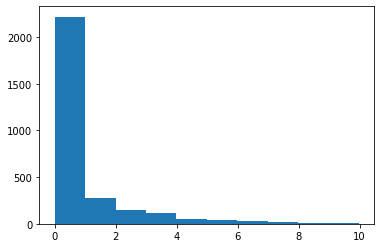

In [ ]:
plt.hist(fun['error'])

In [ ]:
test_x = test_x.merge(df, how='left', left_on=['REAL_GAME_YEAR', 'PLAYER_ID', 'FGM', 'FGA', 'PLUS_MINUS'], right_on=['REAL_GAME_YEAR', 'PLAYER_ID', 'FGM', 'FGA', 'PLUS_MINUS'])

In [ ]:
import math
#test_y = test_y.to_frame()
#test_y = test_y.merge(df, how='inner', )
#test_y = test_y.columns['log_salary']
#train_x['Prediction'] = 10**(0.0005*train_x['FGA']+0.2374*train_x['Primary Position_x']+0.0014*train_x['TO_x']+10.2602*train_x['EFF_FG%_x']+0.7626*train_x['FT_RATE_x'])
#train_x['Prediction'] = 10**(0.4938*train_x['FT_RATE_x']+ 0.2563*train_x['Primary Position_x']+3.2775*train_x['FT_PCT_x']+0.0024*train_x['TO_x']+5.8163*train_x['EFF_FG%_x'])
test_x['Prediction'] = 10**(0.4938*test_x['FT_RATE_x']+0.2563*test_x['Primary Position_x']+3.2775*test_x['FT_PCT_x']+0.0024*test_x['TO_x']+5.8163*test_x['EFF_FG%_x'])
#test_x['Prediction'] = 10**(0.0005*test_x['FGA']+0.2374*test_x['Primary Position_x']+0.0014*test_x['TO_x']+0.7626*test_x['FT_RATE_x'])+10.2602*test_x['EFF_FG%_x']
#test_x = test_x.loc[~(((test_x['FG_PCT_x']>0.7) & (test_x['FGA']<80)) | ((test_x['FT_PCT_x']>0.9) & (test_x['FTA_x']<40))), :]
test_x['error'] = abs(test_x['Prediction']-test_x['Adjusted Salary'])/test_x['Adjusted Salary']
#test_x = test_x[test_x['error']<5]
# average_percent_error = sum(test_x['error'])/len(test_x['error'])

In [ ]:
sum(test_x['error'])/len(test_x['error'])

1.3501164630453173

In [ ]:
test_x[test_x['error']>25]

,REAL_GAME_YEAR,PLAYER_ID,FGM,FGA,FG_PCT_x,FG3M_x,FG3A_x,FG3_PCT_x,FTM_x,FTA_x,...,3FG_PCT_y,FT_RATE_y,EFF_FG%_y,Year,CPI,Adjusted Salary,Primary Position_y,log_salary,Prediction,error
163,2016.0,35812348,56.0,102.0,0.54902,0.0,2.0,0.0,12.0,14.0,...,0.0,0.137255,0.54902,2016,241.4,300228.679611,3,5.477452,7.885422e+06,25.264719
869,2006.0,5865830,240.0,400.0,0.60000,0.0,0.0,0.0,141.0,173.0,...,0.0,0.432500,0.60000,2006,201.6,473684.675595,2,5.675489,1.282347e+07,26.071754
870,2006.0,5865830,240.0,400.0,0.60000,0.0,0.0,0.0,141.0,173.0,...,0.0,0.432500,0.60000,2006,201.6,473684.675595,2,5.675489,1.282347e+07,26.071754


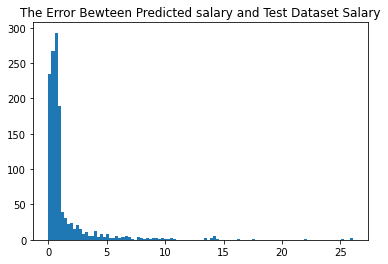

In [ ]:
# test_x = test_x[test_x['error']>100]
plt.hist(test_x['error'], bins=100)
plt.title('The Error Bewteen Predicted salary and Test Dataset Salary')
plt.axis()
plt.show()